# Praca domowa 5

## Import i preprocessing danych

In [1]:
import pandas as pd
import numpy as np

data = pd.read_stata("hcmst.dta")

num1 = "Q34"             # Ocena jakości związku
num2 = "ppeduc"          # Najwyzszy zdobyty poziom edukacji
num3 = "Q9"              # Wiek partnera
cat1 = "Q19"             # Czy mieszkacie ze sobą obecnie?
cat2 = "Q12"             # Polityczne preferencje partnera
label = "S1"             # Czy jesteście małżeństwem

data = data[[num1,num2,cat1,cat2,num3,label]].dropna()
data.rename(columns={'Q9':'partners_age','Q34':'rel_quality','ppeduc':'education','Q19':'living_together','Q12':'partner_politics'}, inplace=True)
data.head()

,rel_quality,education,living_together,partner_politics,partners_age,S1
1,Excellent,Masters degree,Yes,Leans Republican,52,"Yes, I am Married"
2,Good,Masters degree,Yes,Leans Democrat,45,"Yes, I am Married"
4,Excellent,Bachelors degree,Yes,Strong Democrat,59,"Yes, I am Married"
5,Good,HIGH SCHOOL GRADUATE - high school DIPLOMA or ...,Yes,Undecided/Independent/Other,60,"Yes, I am Married"
6,Excellent,HIGH SCHOOL GRADUATE - high school DIPLOMA or ...,Yes,Leans Republican,67,"Yes, I am Married"


In [2]:
from sklearn import preprocessing
    
le = preprocessing.LabelEncoder()

for column_name in data.columns:
    if column_name == "rel_quality":
        data[column_name] = data[column_name].map({
            'Refused':-1, 
            'Excellent':5, 
            "Good":4, 
            "Fair":3, 
            "Poor":2, 
            "Very poor":1
        })
    
    if column_name == "education":
        data[column_name] = data[column_name].map({
            'No formal education':1, 
            '1st, 2nd, 3rd, or 4th grade':2, 
            '5th or 6th grade':3,
            '7th or 8th grade':4,
            '9th grade':5,
            '10th grade':6,        
            '11th grade':7, 
            '12th grade no diploma':8,
            'HIGH SCHOOL GRADUATE - high school DIPLOMA or the equivalent (GED)':9,
            'Some college, no degree':10,
            'Bachelors degree':11,
            'Masters degree':12,
            'Associate degree':13,
            'Professional or Doctorate degree':14
        })
        
    if column_name == 'partner_politics':
         data[column_name] = data[column_name].map({
            'Strong Republican' :1,
            'Not Strong Republican' :2,
            'Leans Republican' :3,
            'Undecided/Independent/Other' :4,
            'Leans Democrat' :5,
            'Not Strong Democrat' :6,   
            'Strong Democrat' :7
           })
    
    if column_name == 'living_together':
         data[column_name] = data[column_name].map({
            'Refused' :-1,
            'Yes' :1,
            'No' :2
         })
            
    if column_name != 'rel_quality' and column_name != 'education' and column_name != 'partner_politics' and column_name != 'living_together' and hasattr(pd.Series(data[column_name], dtype='category'), 'cat'):
        data[column_name] = le.fit_transform(data[column_name].astype(str))
             
    else:
        pass

In [3]:
from sklearn.model_selection import train_test_split

data = data.dropna()

y = data.loc[:,'S1']
X = data.loc[:, data.columns != 'S1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1851, 5), (912, 5), (1851,), (912,))

## Funkcje rysujące wykresy:

### Wykres SHAP

In [4]:
import random
import matplotlib.pyplot as plt

def plot_permutated_loss_drop(model, xtest, ytest, base_acc):
    
    features = list(xtest)
    deltas = []
    
    for i in range(len(features)):
        X_temp = xtest.copy()
        permutate_values = list(X_temp[features[i]])
        random.shuffle(permutate_values)
        X_temp[features[i]] = permutate_values
        ypred = model.predict(X_temp)
        deltas.append(abs(base_acc-accuracy_score(ytest,ypred)))
    
    
    fig, ax = plt.subplots()
    ax.barh(features, deltas, align='center',
        color='green')
    ax.set_xlim(left=0.0,right=0.18)
    ax.invert_yaxis() 
    
    plt.show()
        
    return

### Wykres PDP

In [5]:
import matplotlib.pyplot as plt

def ceteris_paribus_plot(model,train,num_feature,n1):
    X_temp_1 = train.copy().head(n1)
    
    f_min, f_max = data[num_feature].min(), data[num_feature].max()
    start, stop = (f_min, f_max)
    num_feature_values = np.linspace(start, stop, n1, dtype=int)
    
    X_temp_1[num_feature] = num_feature_values

    y_pred = model.predict_proba(X_temp_1)[:, 1]
    pred_values = pd.DataFrame({'Feature_value':num_feature_values,'Prediction':y_pred})
    
    return pred_values.drop_duplicates().reset_index(drop=True)

### Wykres Mplot porównujący dwa modele

In [6]:
def Mplot(models,names,dataset,chosen_feature,n):
    
    plt.figure(figsize=(8,6))
    
    for model,name in zip(models,names):
        
        sample = dataset.sample(n).reset_index(drop=True)
        results = pd.DataFrame(columns=['Feature_value', 'Prediction'])

        for i in range(n):
            X_temp = dataset.copy()
            X_temp.loc[:,'living_together'] = int(sample.iloc[i]['living_together'])
            X_temp.loc[:,'partner_politics'] = int(sample.iloc[i]['partner_politics'])
            X_temp.loc[:,'rel_quality'] = int(sample.iloc[i]['rel_quality'])
            X_temp.loc[:,'education'] = int(sample.iloc[i]['education'])
            X_temp.loc[:,'partners_age'] = int(sample.iloc[i]['partners_age'])

            tmp = ceteris_paribus_plot(model,X_temp,chosen_feature,n)
            results = results.append(tmp, ignore_index=True)   

        feature_values = sorted(list(dataset[chosen_feature].drop_duplicates()))
        mean_values = []

        for i in range(1,len(feature_values)+1):
            tmp = np.mean(results[results.Feature_value.isin([i-1,i,i+1])])['Prediction']
            mean_values.append(tmp)

        plt.plot(feature_values, mean_values,linewidth=3,label='%s' % name)
        plt.legend()
        plt.xlabel(chosen_feature)
        plt.ylabel("Prawdopodobieństwo małżeństwa")

## Wyjaśniany model 1

In [7]:
#from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

random_forest = RandomForestClassifier(n_estimators=100, max_depth=3,random_state=25)

y_pred = random_forest.fit(X_train,y_train).predict(X_test)
acc = accuracy_score(y_test,y_pred)
print("Model accuracy score: " + str(acc))

Model accuracy score: 0.8629385964912281


## Wyjaśniany model 2

In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb = XGBClassifier(n_estimators=100, max_depth=3,random_state=25)

y_pred = xgb.fit(X_train,y_train).predict(X_test)
acc = accuracy_score(y_test,y_pred)
print("Model accuracy score: " + str(acc))

Model accuracy score: 0.8585526315789473


## Porównanie ważności zmiennych w dwóch modelach

Random Forest:


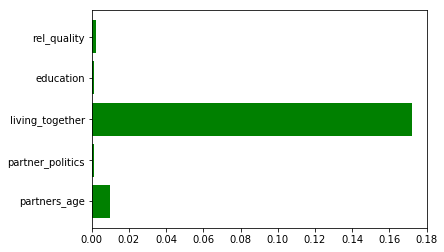

XGBoost:


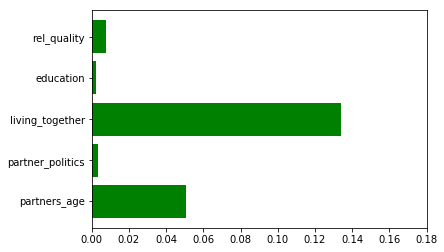

In [9]:
print("Random Forest:")
plot_permutated_loss_drop(random_forest, X_test, y_test, 0.8629385964912281)
print("XGBoost:")
plot_permutated_loss_drop(xgb, X_test, y_test, 0.8585526315789473)

## Porównanie z wykresami Ceteris Paribus

Poniżej przedstawiono 5 wykresów MPlot dla 5 zmiennych.

Na każdym z wykresów można porównać w jaki sposób dla każdego z modeli zależy odpowiedź modelu od wartości danej zmiennej.

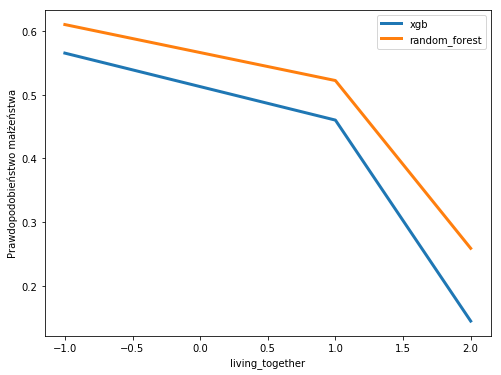

In [10]:
Mplot([xgb,random_forest],["xgb","random_forest"],X_train,"living_together",50)

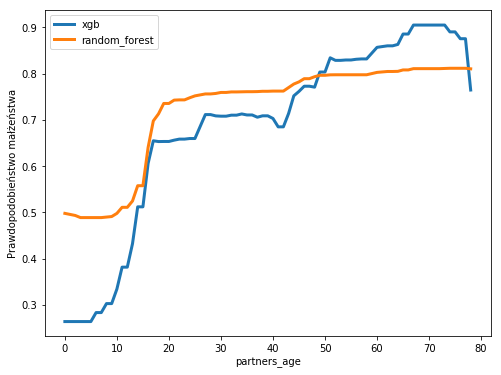

In [169]:
Mplot([xgb,random_forest],["xgb","random_forest"],X_train,"partners_age",50)

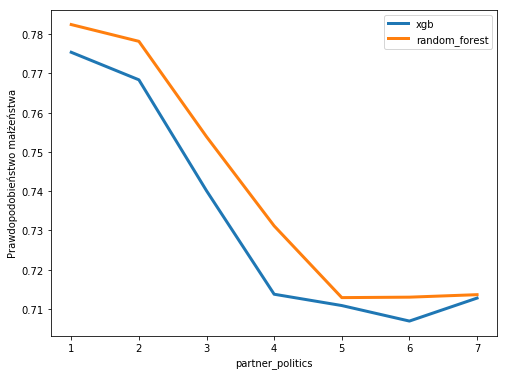

In [171]:
Mplot([xgb,random_forest],["xgb","random_forest"],X_train,"partner_politics",50)

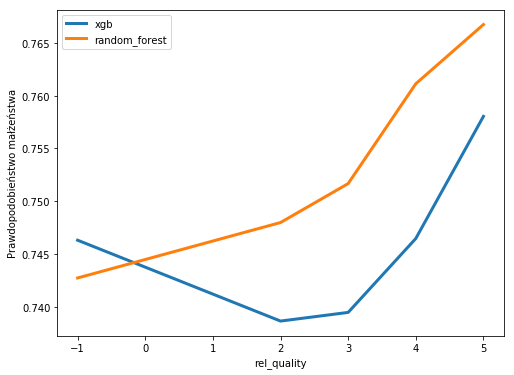

In [172]:
Mplot([xgb,random_forest],["xgb","random_forest"],X_train,"rel_quality",50)

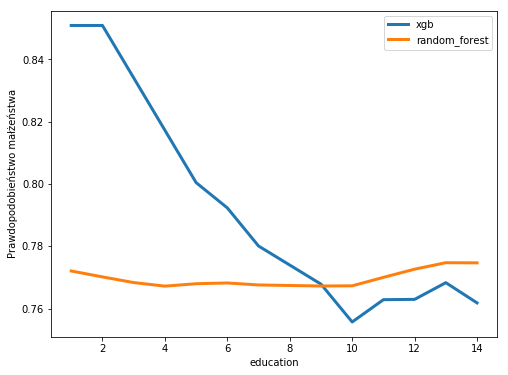

In [173]:
Mplot([xgb,random_forest],["xgb","random_forest"],X_train,"education",50)

## Wnioski

Porównując wyniki wykresów SHAP oraz Mplot można dojść do wniosku, że wyniki się potwierdzają. 

Z wykresów SHAP wynika, że największy wpływ na odpowiedź modelu:
* dla modelu Random Forest zdecydowanie największy wpływ ma zmienna *living together*, również zauważalny ma *partners_age*, a wszystkie pozostałe są właściwie nieistotne
* dla modelu XGBoost również zdecydowanie największy wpływ ma zmienna *living_together*, ale widać wyraźnie większe w porównaniu do poprzedniego modelu wpływy pozostałych zmiennych 

Na wykresach Mplot można zauważyć, że różnice pomiędzy odpowiedziami modelu są często bardzo nieznaczne w zależności od wartości zmiennej (jest niewielka rozbieżność wartości na osi y). Pokrywa się to z tym, co wynikało z wykresów SHAP: największa rozbieżność w stosunku do wartości zmiennej występuje na wykresie zmiennej *living_together*.

Wykresy Mplot zmiennej *partners_age* różnią się pomiędzy dwoma modelami i widać, że dla modelu Random Forest zmienność odpowiedzi jest mniejsza niż w modelu XGBoost, co znowu pokrywa się z wynikami wykresu SHAP - według modelu Random Forest ta zmienna jest mniej istotna niż według modelu XGBoost.

Interesująca jest również zmienna *education*, która dla modelu Random Forest jest właściwie linią prostą (co sugerowałoby prawie zerowy wpływ na model), a model XGBoost rozróżnia odpowiedzi dla różnych wartości tej zmiennej. Te wyniki nie do końca pokrywają się z wynikami wykresu SHAP.
